# Understanding Basics of Bayesian Linear Regression

Another data scientist was studying Bayesian statistics and recently complained to me that everyone always uses the same simple coin-flipping examples to illustrate Bayesian concepts.  How does it work in something more complicated like linear regression?  To answer his question, I decided to radically simplify the Bayesian linear regression problem so that someone can (hopefully) easily follow the arithmetic.

Let's first look at Bayes's rule:

$$P(A \mid B) = \frac{P(B \mid A) \, P(A)}{P(B)}$$

In words, we might say:

$$posterior = \frac{likelihood \ x \ prior}{scaling \ factor}$$

Or, in more words, the posterior distribution is proportional to the product of the likelihood function and the prior distribution.  Then to make that product into a probability distribution, we divide it by a scaling factor (which is the likelihood averaged over the prior) so that all the probabilities sum to 1.

In simple linear regression, we have a predictor variable $x$ that will predict the response variable $y$.  We will model the relationship between $x$ and $y$ as a line.  And our predictions won't be exact, so we need to account for how much error our predictions have, that is, how much the actual data points deviate from our model line.  As an equation:

$$y_i = \beta_0 + \beta_1 x_i + \epsilon_i$$

where $i$ specifies which data point we're talking about ($i = 1, 2, 3... n$, where $n$ is the number of data points).

Our task in the linear regression problem is to find values of the coefficients $\beta_0$ and $\beta_1$ that minimize the error $\epsilon$ -- so that the line lies as close to all the actual data points as possible.  The coefficient $\beta_0$ specifies the $y$-axis intercept for the line, and the coefficient $\beta_1$ specifies the slope of the line.

In Bayesian linear regression, we're going to put priors on each of the coefficients -- one prior for $\beta_0$ and one for $\beta_1$.  Then we'll calculate the corresponding likelihoods for the actual data points that we observe, given the values of our parameters.  Then we'll follow Bayes's rule by multiplying the priors and likelihood and dividing that product by the scaling factor.

We're going to drastically simplify the problem in two ways:

1. We're going to assume the coefficients' distributions are discrete, not continuous.  Instead of being able to assume any value (e.g., 1, 1.333333, 3.14159, 8.99999999), the coefficients can assume only values at fixed intervals (e.g., 0, 0.5, 1, 1.5, 2, 2.5, 3...).  This will make our scaling factor much easier to calculate.  With continuous distributions, we would usually have to calculate an integral or do some fancy sampling, which makes things much more complicated and difficult to understand.  But with the discrete distribution, we can just do some simple arithmetic.

2. We're going to restrict the range that our coefficients can assume.  That way, we'll have just a few numbers to keep track of, instead of hundreds or thousands.  That'll make the math much easier to follow for our little brains.

### Helpful functions

Before we get started, we'll need some functions.  This first one will basically "do" our linear regression:  it'll predict our response variable $y$ based on our predictor variable $x$ and our parameters, the coefficients $\beta_0$ and $\beta_1$.

In [55]:
def predict_y(xs, parameters):
    '''
    Returns dot product of 'xs' and 'parameters' where 'xs' is the predictor
        variables matrix and 'parameters' are the coefficients for linear
        regression
    xs - n x p numpy array where 'n' is number of cases and 'p' is number of
        parameters
    parameters - p x m numpy array where 'p' is number of parameters and 'm'
        is the number of sets of parameters
    If the first column of 'xs' is not a column of ones for the regression
        intercept, the function adds that column
    '''
    import numpy as np
    ones = np.ones(len(xs))
    if not np.allclose(xs[:, 0], ones):
        xs = np.concatenate((ones.reshape(-1, 1), xs), axis=1)
    #if not xs.shape[1] != len(parameters):
    #    parameters = parameters.T
    predicted_y = np.dot(xs, parameters)
    return(predicted_y)

This second function will calculate the likelihood for our linear regression model based on the predicted response variable $y$ and the actual, observed data points for $y$.

In [56]:
def get_regress_likelihood(actual_y, predicted_y):
    '''
    Returns likelihood of a linear regression model given the response variable
        ('actual_y') and the model's predictions of the response variable
        ('predicted_y')
    'actual_y' and 'predicted_y' are numpy arrays of equal length
    '''
    if len(actual_y) != len(predicted_y):
        return('Response variable and predicted response variable must be same \
               length')
    import numpy as np
    n = len(actual_y)
    error = actual_y - predicted_y
    s = np.std(error)
    likelihood = ( ( (1 / (2 * np.pi * s**2))**(n/2) ) *
                  np.exp(-1 * (np.dot(error.T, error) / (2 * s**2))) )
    return(likelihood)

Let's play with some data!

### Helpful packages

We'll need some Python packages:

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import pystan

### Generate data

First, we're going to create some data that we can fit a regression model to.  To further simplify the problem, we're going to set the $y$-intercept $\beta_0$ to zero both here during data generation and later when we fit the model.  That way, we'll calculate Bayes's rule for only one parameter $\beta_1$.

In [58]:
n = 5                            # number of data points
x = np.arange(n) + 1             # predictor variable
b0 = 0                           # beta 0, y-intercept
b1 = 1.5                         # beta 1, slope
np.random.seed(38502115)
eps = 0.7 * np.random.randn(n)   # epsilon, error term
y = b0 + b1*x + eps              # response variable

Here's the data we generated:

In [59]:
data_1 = pd.DataFrame({'x': x, 'y': y})
data_1

,x,y
0,1,1.609501
1,2,3.118044
2,3,5.491070
3,4,6.734883
4,5,6.313860


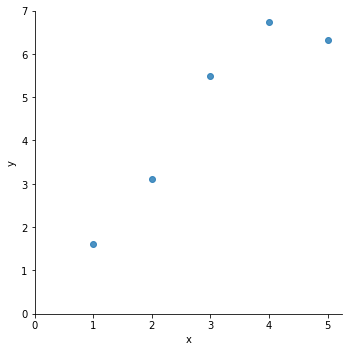

In [60]:
data1_plot = sns.lmplot(x='x', y='y', data=data_1, fit_reg=False)
axes = data1_plot.axes
axes[0, 0].set_xlim(0, )
axes[0, 0].set_ylim(0, )
data1_plot.fig

## Part I.  Discrete distribution, 1 parameter

### I) A. Set the prior

Now that we've created our data set, we can start our modeling process.  The first step is to choose a prior for the coefficient $\beta_1$.  You'll recall that we're going to restrict the prior to only a few possible, discrete values in order to simplify the regression problem.  Let's set the possible values that $\beta_1$ can assume:

In [61]:
b1_n = 5                           # number of values that beta 1 can assume
b1_lower_bound = np.floor(b1)      # lower bound for beta 1
b1_upper_bound = np.ceil(b1)       # upper bound for beta 1
b1_possible_values = np.linspace(b1_lower_bound, b1_upper_bound, num=b1_n)
b1_possible_values

array([ 1.  ,  1.25,  1.5 ,  1.75,  2.  ])

Now we need to set the prior probabilities that each of these values can occur.  We're simply going to set a flat prior so that all the possible values of $\beta_1$ have an equal probability:

In [62]:
b1_prior = np.full(b1_n, 1/b1_n)
b1_prior

array([ 0.2,  0.2,  0.2,  0.2,  0.2])

Our flat prior is plotted below:

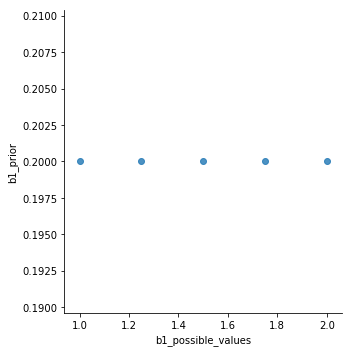

In [69]:
b1_prior_plot = sns.lmplot(x='b1_possible_values',
                           y='b1_prior',
                           data=b1_data,
                           fit_reg=False)
b1_prior_plot.fig

### I) B. Calculate the likelihood

Now that we've set the prior, we need to calculate the likelihood of the data given our model at all possible values of the parameter $\beta_1$.

Let's set up our matrix of parameters.  Remember that we've set the $y$-intercept coefficient $\beta_0$ to zero for both generating the data and for modeling it, so it shows up as a row of zeroes.  The other row comprises all our possible values for $\beta_1$.

In [63]:
parameters = np.array([np.zeros(b1_n), b1_possible_values])
parameters

array([[ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 1.  ,  1.25,  1.5 ,  1.75,  2.  ]])

Now we predict our response variable $y$ based on the predictor variable $x$ and our parameters:

In [64]:
predicted_y = predict_y(x.reshape(-1, 1), parameters)

parameter_names = ['b1=' + str(parameters[1, i])
                   for i in range(parameters.shape[1])]
x_names = ['x=' + str(x[i]) for i in range(len(x))]
predicted_y_df = pd.DataFrame(predicted_y,
                              index=x_names,
                              columns=parameter_names)
predicted_y_df

,b1=1.0,b1=1.25,b1=1.5,b1=1.75,b1=2.0
x=1,1.0,1.25,1.5,1.75,2.0
x=2,2.0,2.50,3.0,3.50,4.0
x=3,3.0,3.75,4.5,5.25,6.0
x=4,4.0,5.00,6.0,7.00,8.0
x=5,5.0,6.25,7.5,8.75,10.0


Just to be sure it's clear, the first column in the table above says that if the coefficient $\beta_1$ equals $1$, then the response variable $y$ will be $1$ where $x = 1$.  It'll be $2$ where $x = 2$, $3$ where $x = 3$, and so on.  The corresponding predictions for the other possible values of $\beta_1$ are in the remaining columns of the table.

Now we can use our predicted values of $y$ in the table above to calculate the likelihoods of the actual $y$ that we observed for each of the possible values of $\beta_1$:

In [65]:
likelihood = np.array([get_regress_likelihood(y, predicted_y[:, i])
                       for i in range(predicted_y.shape[1])])
likelihood

array([  8.63109035e-08,   7.79737936e-05,   3.08239565e-03,
         4.08595504e-04,   1.44545600e-05])

The likelihood function peaks at $1.5$, which we would expect because -- unknown to the model -- that's the value of $\beta_1$ that we used to generate the data.  The likelihoods are plotted below:

/home/zh/anaconda3/envs/jupyter_plot_stan/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


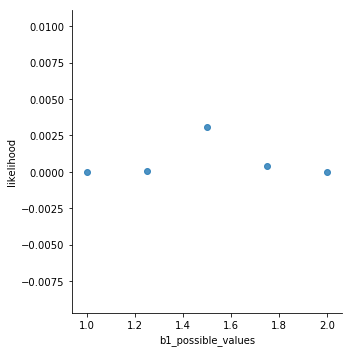

In [142]:
b1_likelihood_plot = sns.lmplot(x='b1_possible_values',
                                y='likelihood',
                                data=b1_data,
                                fit_reg=False)
b1_likelihood_plot.fig

### I) C. Calculate the posterior with Bayes's rule

Now that we've determined the prior distribution and the likelihood function, we can use Bayes's rule to calculate the posterior distribution.

Notice below that our scaling factor is simply the sum of the prior-likelihood products for each of our possible values of $\beta_1$.  This is the place where, if we were using a continuous distribution to model $\beta_1$, we would have to calculate an integral.  But because we simplified the problem by using a discrete distribution, we can just use arithmetic, which is much easier than calculus!

In [66]:
b1_posterior_unscaled = b1_prior * likelihood
b1_posterior = b1_posterior_unscaled / np.sum(b1_posterior_unscaled)
b1_posterior

array([  2.40856044e-05,   2.17590811e-02,   8.60162033e-01,
         1.14021164e-01,   4.03363654e-03])

Since we used a flat prior, the posterior distribution below has the same shape as the likelihood function that we plotted above -- only the scales are different.  Clearly, the value of $1.5$ is the most probable value for $\beta_1$:

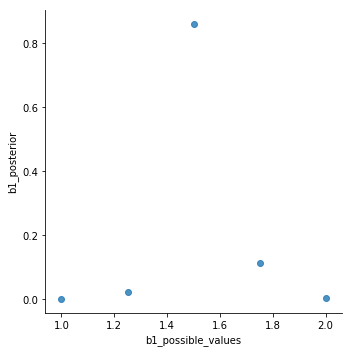

In [71]:
b1_posterior_plot = sns.lmplot(x='b1_possible_values',
                               y='b1_posterior',
                               data=b1_data,
                               fit_reg=False)
b1_posterior_plot.fig

If we calculated our scaling factor correctly, then all the probabilities of the posterior distribution should add up to $1$.  And they do:

In [67]:
sum(b1_posterior)

1.0000000000000002

### I) D. Plot regression line

Below is the plot of our data and the single most probable regression line, based on our posterior distribution where $\beta_0 = 0$ and $\beta_1 = 1.5$:

/home/zh/anaconda3/envs/jupyter_plot_stan/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


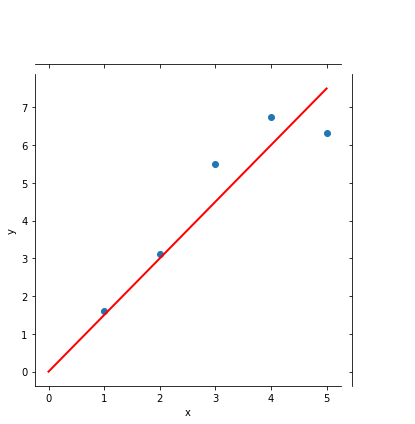

In [132]:
model_b0 = 0
model_b1 = 1.5

grid = sns.JointGrid(data_1['x'], data_1['y'])
grid.plot_joint(plt.scatter)
grid.ax_joint.plot([0, max(x)], [model_b0, max(x)*model_b1], 'r-', linewidth=2)
grid.fig

### I) E. Summarize

Let's summarize how we calculated the posterior distribution.

In [68]:
b1_data = pd.DataFrame({'b1_possible_values': b1_possible_values,
                        'b1_prior': b1_prior})
b1_data['likelihood'] = likelihood
b1_data['b1_posterior_unscaled'] = b1_posterior_unscaled
b1_data['b1_posterior'] = b1_posterior
b1_data.style.set_precision(3)

,b1_possible_values,b1_prior,likelihood,b1_posterior_unscaled,b1_posterior
0,1,0.2,8.63e-08,1.73e-08,2.41e-05
1,1.25,0.2,7.8e-05,1.56e-05,0.0218
2,1.5,0.2,0.00308,0.000616,0.86
3,1.75,0.2,0.000409,8.17e-05,0.114
4,2,0.2,1.45e-05,2.89e-06,0.00403


The table above shows all the possible values of the parameter $\beta_1$.  For each of these values, we set a prior probability, calculated a likelihood, and found the products of the priors and likelihoods.  Then we divided all the products by a common scaling factor so that they all added up to $1$.  That gave us a proper probability distribution -- the posterior.

We'll follow the same process in the next section, where we'll work with two parameters.  In addition to $\beta_1$, we'll allow $\beta_0$ to vary.

## Part II.  Discrete distributions, 2 parameters

For our linear regression problem, we calculated a posterior distribution for one parameter, the coefficient $\beta_1$, which is the slope of the regression line.  Let's make the problem a bit more complex and realistic by calculating posterior distributions for both $\beta_0$, the $y$-intercept of the regression line, and $\beta_1$.

### II) A. Generated data

We'll use the same data that we generated previously, based on the same parameters where $\beta_0 = 0$ and $\beta_1 = 1.5$:

In [73]:
data_1

,x,y
0,1,1.609501
1,2,3.118044
2,3,5.491070
3,4,6.734883
4,5,6.313860


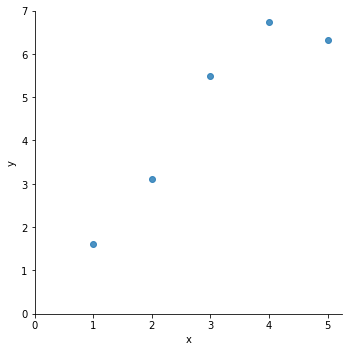

In [74]:
data1_plot.fig

### II) B. Set the prior

We'll use the same prior for $\beta_1$:

In [75]:
b1_possible_values

array([ 1.  ,  1.25,  1.5 ,  1.75,  2.  ])

In [76]:
b1_prior

array([ 0.2,  0.2,  0.2,  0.2,  0.2])

We'll set a prior for $\beta_0$ much like we did for $\beta_1$.  First we'll set a few possible, discrete values for $\beta_0$:

In [77]:
b0_n = 5                           # number of values that beta 0 can assume
b0_lower_bound = b0 - 1            # lower bound for beta 0
b0_upper_bound = b0 + 1            # upper bound for beta 0
b0_possible_values = np.linspace(b0_lower_bound, b0_upper_bound, num=b0_n)
b0_possible_values

array([-1. , -0.5,  0. ,  0.5,  1. ])

Then we'll define a flat prior over those possible values for $\beta_0$:

In [78]:
b0_prior = np.full(b0_n, 1/b0_n)
b0_prior

array([ 0.2,  0.2,  0.2,  0.2,  0.2])

Now we need to define the joint prior over every combination of $\beta_0$ and $\beta_1$.  Since these two distributions are independent, we can simply multiply the probabilities together to obtain the joint probability for each combination, as shown in the table below:

In [79]:
b0_b1_joint_prior = np.outer(b0_prior, b1_prior)

b0_names = ['b0=' + str(b0_possible_values[i])
            for i in range(len(b0_possible_values))]
b1_names = ['b1=' + str(b1_possible_values[i])
            for i in range(len(b1_possible_values))]
b0_b1_joint_prior_df = pd.DataFrame(b0_b1_joint_prior,
                                   index=b0_names,
                                   columns=b1_names)
b0_b1_joint_prior_df

,b1=1.0,b1=1.25,b1=1.5,b1=1.75,b1=2.0
b0=-1.0,0.04,0.04,0.04,0.04,0.04
b0=-0.5,0.04,0.04,0.04,0.04,0.04
b0=0.0,0.04,0.04,0.04,0.04,0.04
b0=0.5,0.04,0.04,0.04,0.04,0.04
b0=1.0,0.04,0.04,0.04,0.04,0.04


Here's an alternative look at the joint prior of $\beta_0$ and $\beta_1$ as a plot:

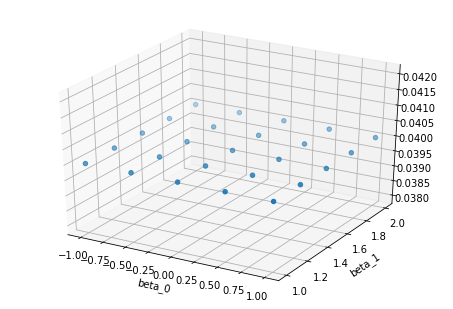

In [80]:
b0_b1_combos = (np.array(np.meshgrid(b0_possible_values, b1_possible_values))
                .T.reshape(-1, 2))
b0_b1_joint_prior_flat = np.concatenate((
    b0_b1_combos, b0_b1_joint_prior.flatten().reshape(-1, 1)), axis=1)

plt.close('all')
fig = plt.figure()
ax = Axes3D(fig)
ax.set_xlabel('beta_0')
ax.set_ylabel('beta_1')
ax.scatter(b0_b1_joint_prior_flat[:, 0],
           b0_b1_joint_prior_flat[:, 1],
           b0_b1_joint_prior_flat[:, 2],)
plt.show()

### II) C. Calculate the likelihood

Now that we've set the joint prior, we need to calculate the likelihood of the data given our model at all possible values of the parameters $\beta_0$ and $\beta_1$.

Let's set up our matrix of parameters.  Since each parameter can assume several values, we need to calculate the likelihood at every combination of the values of those parameters

In [81]:
parameters = b0_b1_combos.T

b0_b1_combos_df = pd.DataFrame(b0_b1_combos,
                               columns=['beta_0', 'beta_1'])
b0_b1_combos_df

,beta_0,beta_1
0,-1.0,1.00
1,-1.0,1.25
2,-1.0,1.50
3,-1.0,1.75
4,-1.0,2.00
5,-0.5,1.00
6,-0.5,1.25
7,-0.5,1.50
8,-0.5,1.75
9,-0.5,2.00


Now we predict our response variable $y$ based on the predictor variable $x$ and our parameters:

In [94]:
predicted_y = predict_y(x.reshape(-1, 1), parameters)

parameter_names = ['b0=' + str(parameters[0, i]) +
                   ', b1=' + str(parameters[1, i])
                   for i in range(parameters.shape[1])]
predicted_y_df = pd.DataFrame(predicted_y.T,
                              columns=x_names)

overall_df = pd.concat((b0_b1_combos_df, predicted_y_df), axis=1, ignore_index=False)
overall_df

,beta_0,beta_1,x=1,x=2,x=3,x=4,x=5
0,-1.0,1.00,0.00,1.0,2.00,3.0,4.00
1,-1.0,1.25,0.25,1.5,2.75,4.0,5.25
2,-1.0,1.50,0.50,2.0,3.50,5.0,6.50
3,-1.0,1.75,0.75,2.5,4.25,6.0,7.75
4,-1.0,2.00,1.00,3.0,5.00,7.0,9.00
5,-0.5,1.00,0.50,1.5,2.50,3.5,4.50
6,-0.5,1.25,0.75,2.0,3.25,4.5,5.75
7,-0.5,1.50,1.00,2.5,4.00,5.5,7.00
8,-0.5,1.75,1.25,3.0,4.75,6.5,8.25
9,-0.5,2.00,1.50,3.5,5.50,7.5,9.50


Each combination of $\beta_0$ and $\beta_1$ is shown on its own row in the table above.  The predictions of the linear model with that combination of parameter values is shown across the remaining columns of that row.  Each of these columns represents a different $x$ value.

Now we can use our predicted values of $y$ in the table above to calculate the likelihoods of the actual $y$ that we observed for each of the possible combinations of $\beta_0$ and $\beta_1$:

In [95]:
likelihood = np.array([get_regress_likelihood(y, predicted_y[:, i])
                       for i in range(predicted_y.shape[1])])

likelihood_df = pd.DataFrame(likelihood,
                             columns=['likelihood'])

overall_df = pd.concat((overall_df, likelihood_df), axis=1, ignore_index=False)
overall_df

,beta_0,beta_1,x=1,x=2,x=3,x=4,x=5,likelihood
0,-1.0,1.00,0.00,1.0,2.00,3.0,4.00,9.626421e-15
1,-1.0,1.25,0.25,1.5,2.75,4.0,5.25,5.439089e-11
2,-1.0,1.50,0.50,2.0,3.50,5.0,6.50,9.734922e-06
3,-1.0,1.75,0.75,2.5,4.25,6.0,7.75,7.027992e-04
4,-1.0,2.00,1.00,3.0,5.00,7.0,9.00,2.612297e-04
5,-0.5,1.00,0.50,1.5,2.50,3.5,4.50,7.300197e-11
6,-0.5,1.25,0.75,2.0,3.25,4.5,5.75,2.301751e-07
7,-0.5,1.50,1.00,2.5,4.00,5.5,7.00,5.211130e-04
8,-0.5,1.75,1.25,3.0,4.75,6.5,8.25,1.081616e-03
9,-0.5,2.00,1.50,3.5,5.50,7.5,9.50,9.421658e-05


In the table above, we've added a new column showing the likelihoods for every possible combination of $\beta_0$ and $\beta_1$.  The plot below shows the same thing:

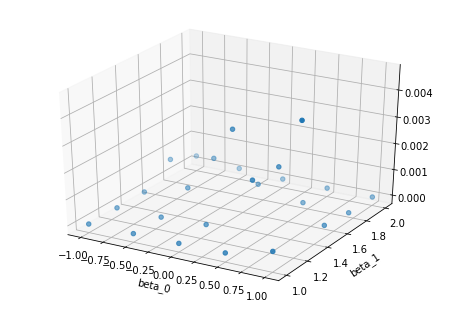

In [30]:
b0_b1_likelihood = np.concatenate((
    b0_b1_combos, likelihood.reshape(-1, 1)), axis=1)

fig = plt.figure()
ax = Axes3D(fig)
ax.set_xlabel('beta_0')
ax.set_ylabel('beta_1')
ax.scatter(b0_b1_likelihood[:, 0],
           b0_b1_likelihood[:, 1],
           b0_b1_likelihood[:, 2],)
plt.show()

The details in the 3-dimensional plot above are somewhat difficult to see, but it's clear that several of the parameter combinations are substantially more likely than others.

In [31]:
np.tile(b0_possible_values, (b1_n, 1))

array([[-1. , -0.5,  0. ,  0.5,  1. ],
       [-1. , -0.5,  0. ,  0.5,  1. ],
       [-1. , -0.5,  0. ,  0.5,  1. ],
       [-1. , -0.5,  0. ,  0.5,  1. ],
       [-1. , -0.5,  0. ,  0.5,  1. ]])

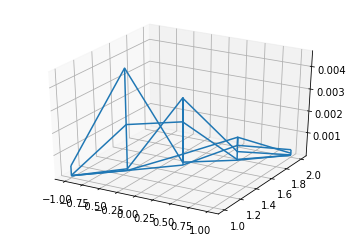

In [32]:
from mpl_toolkits.mplot3d import axes3d
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

b0_tiled = np.tile(b0_possible_values, (b1_n, 1))
b1_tiled = np.tile(b1_possible_values, (b0_n, 1))
likelihood_tile = b0_b1_likelihood[:, 2].reshape(b0_n, b1_n)

# Grab some test data.
X, Y, Z = axes3d.get_test_data(0.05)

# Plot a basic wireframe.
#ax.plot_wireframe(X, Y, Z, rstride=10, cstride=10)
ax.plot_wireframe(b0_tiled, b1_tiled, likelihood_tile)

plt.show()

### II) D. Calculate the posterior with Bayes's rule

Now that we've determined the joint prior distribution and the joint likelihood function, we can use Bayes's rule to calculate the joint posterior distribution.

In [96]:
b0_b1_posterior_unscaled = b0_b1_joint_prior_flat[:, 2] * likelihood
b0_b1_posterior = b0_b1_posterior_unscaled / np.sum(b0_b1_posterior_unscaled)

b0_b1_posterior_df = pd.DataFrame(b0_b1_posterior,
                                  columns=['posterior'])

overall_df = pd.concat((overall_df, b0_b1_posterior_df), axis=1, ignore_index=False)
overall_df

,beta_0,beta_1,x=1,x=2,x=3,x=4,x=5,likelihood,posterior
0,-1.0,1.00,0.00,1.0,2.00,3.0,4.00,9.626421e-15,6.158229e-13
1,-1.0,1.25,0.25,1.5,2.75,4.0,5.25,5.439089e-11,3.479503e-09
2,-1.0,1.50,0.50,2.0,3.50,5.0,6.50,9.734922e-06,6.227640e-04
3,-1.0,1.75,0.75,2.5,4.25,6.0,7.75,7.027992e-04,4.495958e-02
4,-1.0,2.00,1.00,3.0,5.00,7.0,9.00,2.612297e-04,1.671143e-02
5,-0.5,1.00,0.50,1.5,2.50,3.5,4.50,7.300197e-11,4.670094e-09
6,-0.5,1.25,0.75,2.0,3.25,4.5,5.75,2.301751e-07,1.472480e-05
7,-0.5,1.50,1.00,2.5,4.00,5.5,7.00,5.211130e-04,3.333672e-02
8,-0.5,1.75,1.25,3.0,4.75,6.5,8.25,1.081616e-03,6.919332e-02
9,-0.5,2.00,1.50,3.5,5.50,7.5,9.50,9.421658e-05,6.027238e-03


In the table above, we've added a new column showing the posterior probabilities for every possible combination of $\beta_0$ and $\beta_1$.  The plot below shows the same thing:

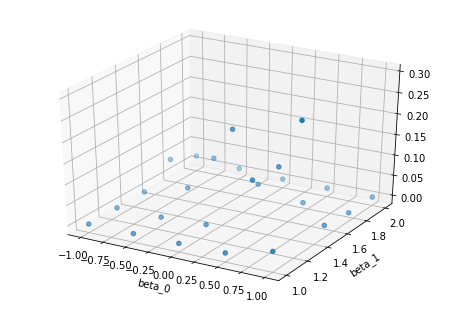

In [34]:
b0_b1_posterior_2 = np.concatenate((
    b0_b1_combos, b0_b1_posterior.reshape(-1, 1)), axis=1)

fig = plt.figure()
ax = Axes3D(fig)
ax.set_xlabel('beta_0')
ax.set_ylabel('beta_1')
ax.scatter(b0_b1_posterior_2[:, 0],
           b0_b1_posterior_2[:, 1],
           b0_b1_posterior_2[:, 2],)
plt.show()

Notice again that because we set a flat joint prior, the joint posterior distribution has the same shape as the joint likelihood.  Only the scale is different between the likelihood and the posterior distribution.

If we calculated our scaling factor correctly, then all the probabilities of the posterior distribution should add up to $1$.  And they do:

In [35]:
sum(b0_b1_posterior)

1.0000000000000002

### II) E. Plot regression line

Below is the plot of our data and the single most probable regression line (in blue), based on our joint posterior distribution where $\beta_0 = 1$ and $\beta_1 = 1.25$.  The red regression line is from our previous model where we set $\beta_0 = 0$ and calculated the posterior distribution only for $\beta_1$, where $1.5$ was the most probable value:

/home/zh/anaconda3/envs/jupyter_plot_stan/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


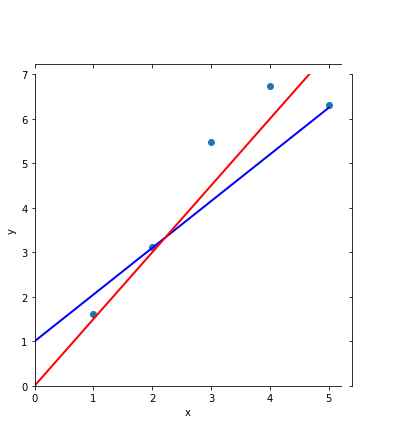

In [133]:
model_b0_1 = 0
model_b1_1 = 1.5

model_b0_2 = 1
model_b1_2 = 1.25

grid = sns.JointGrid(data_1['x'], data_1['y'])
grid.plot_joint(plt.scatter)
plt.xlim(xmin=0)
plt.ylim(ymin=0)
grid.ax_joint.plot([0, max(x)], [model_b0_2, max(x)*model_b1_2], 'b-', linewidth=2)
grid.ax_joint.plot([0, max(x)], [model_b0_1, max(x)*model_b1_1], 'r-', linewidth=2)
grid.fig

### II) F. Look at the marginal posterior distributions of each parameter

If we want to look at the posterior distribution of each parameter, we can use the marginal probabilities.  For $\beta_0$:

In [37]:
b0_b1_posterior_2_df = pd.DataFrame(b0_b1_posterior_2,
                                  index=parameter_names,
                                  columns=['beta_0', 'beta_1', 'posterior'])

b0_posterior_df = (b0_b1_posterior_2_df.drop(['beta_1'], axis=1)
                   .groupby('beta_0')
                   .sum()
                   .reset_index())
b0_posterior_df

,beta_0,posterior
0,-1.0,0.062294
1,-0.5,0.108572
2,0.0,0.229245
3,0.5,0.267650
4,1.0,0.332240


Even though we generated the data with $\beta_0 = 0$, the most probable value for $\beta_0$ (out of the possible values that we allowed) based on the data is $1$.  The table above shows this, as does the corresponding plot below:

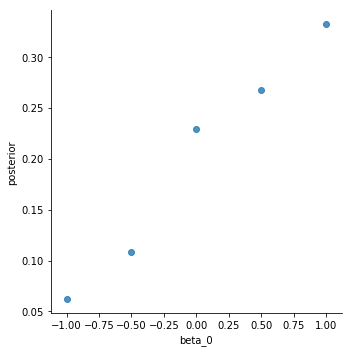

In [38]:
b0_posterior_plot = sns.lmplot(x='beta_0',
                               y='posterior',
                               data=b0_posterior_df,
                               fit_reg=False)
b0_posterior_plot.fig

All the marginal posterior probabilities for $\beta_0$ should sum to $1$, and they do:

In [39]:
b0_posterior_df.loc[:, 'posterior'].sum()

1.0000000000000002

Now let's look at the marginal posterior distribution for $\beta_1$:

In [40]:
b1_posterior_df = (b0_b1_posterior_2_df.drop(['beta_0'], axis=1)
                   .groupby('beta_1')
                   .sum()
                   .reset_index())
b1_posterior_df

,beta_1,posterior
0,1.00,0.030272
1,1.25,0.433895
2,1.50,0.369337
3,1.75,0.142771
4,2.00,0.023725


Even though we generated the data with $\beta_1 = 1.5$, the most probable value for $\beta_1$ (out of the possible values that we allowed) based on the data is $1.25$.  The table above shows this, as does the corresponding plot below:

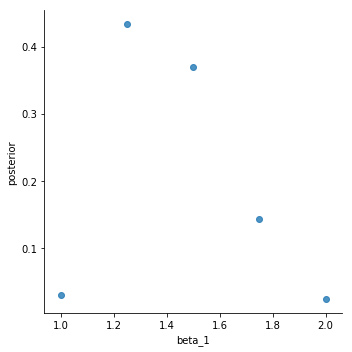

In [41]:
b1_posterior_plot = sns.lmplot(x='beta_1',
                               y='posterior',
                               data=b1_posterior_df,
                               fit_reg=False)
b1_posterior_plot.fig

All the marginal posterior probabilities for $\beta_1$ should sum to $1$, and they do:

In [42]:
b1_posterior_df.loc[:, 'posterior'].sum()

1.0000000000000002

## Part III.  Continuous distributions, 2 parameters

We've now seen a regression problem where we had to calculate the posterior distributions for two parameters, the $y$-intercept of the regression line $\beta_0$ and the slope of the line $\beta_1$.  To simplify the regression problems above, we allowed only a few discrete values over a limited range for each parameter.  Now we're going to make the problem a bit more realistic by switching to continuous distributions for our parameters, but we're going to retain the limited ranges so that the problem is similar to the one above.

Of course, now the calculations will be more complicated.  With a continuous distribution, we now have an infinite number of possible parameter values, so we can't simply multiply the prior and likelihood for every possible parameter value as we did for discrete distributions.  Now we'll need calculus or sampling to figure out the scaling factor in Bayes's rule:

$$posterior = \frac{likelihood \ x \ prior}{scaling \ factor}$$

To handle these complications, we're going to switch to using [Stan](http://mc-stan.org/), which is a probabilistic programming language that interfaces with Python via a package called [PyStan](https://pystan.readthedocs.io/en/latest/).  Stan will handle the sampling automatically, so we're not going to concern ourselves with it any further here.

### III) A. Generated data

We'll use the same data that we generated previously, based on the same parameters where $\beta_0 = 0$ and $\beta_1 = 1.5$:

In [43]:
data_1

,x,y
0,1,1.609501
1,2,3.118044
2,3,5.491070
3,4,6.734883
4,5,6.313860


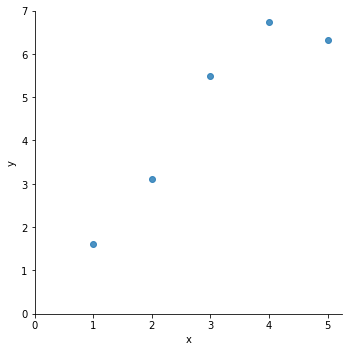

In [44]:
data1_plot.fig

### III) B. Linear regression in Stan

Let's specify our linear regression model in Stan.  Stan programs are organized into blocks of code.  Each block describes different kinds of variables.  We'll save each block into a separate Python string, so that we can conveniently discuss each one in turn.

We start with the data block, where we'll tell Stan what variables we'll pass to it from Python.  In this case, the variables are our predictor variable $x$, our response variable $y$, and the number of data points in each of them $N$.  Notice that $N$ can't be any less than zero, so we set zero as its lower bound:

In [45]:
data_block = '''
data {
  int<lower=0> N;
  vector[N] x;
  vector[N] y;
}
'''

While we're thinking about it, let's go ahead and put those corresponding Python variables into a dictionary that we can pass to Stan:

In [46]:
data_block_variables = {'N': n,
                        'x': x,
                        'y': y}

Next we specify the parameters for our linear regression model:

$$y_i = \beta_0 + \beta_1 x_i + \epsilon_i$$

The parameters are $\beta_0$, $\beta_1$, and $\sigma$, which is the standard deviation of the errors represented by $\epsilon_i$.  As in our previous problem with the discrete distributions, we restrict $\beta_0$ to a range from $-1$ to $1$ and $\beta_1$ to a range from $1$ to $2$.  Notice that we restrict $\sigma$ to be zero or above, because standard deviation cannot be negative:

In [47]:
parameters_block = '''
parameters {
  real<lower=-1, upper=1> beta_0;
  real<lower=1, upper=2> beta_1;
  real<lower=0> sigma;
}
'''

Finally, we specify the model itself.  The response variable $y$ is normally distributed with a mean and standard deviation as its two parameters.  The mean is predicted from our linear regression model, which depends on the parameters $\beta_0$ and $\beta_1$.  The standard deviation is denoted as $\sigma$.  We can also specify the prior distributions for $\beta_0$, $\beta_1$, and $\sigma$ here.  If we don't explicitly specify prior distributions for these parameters, Stan will choose a default uninformative "flat" prior for us.

In [48]:
model_block = '''
model {
  y ~ normal(x * beta_1 + beta_0, sigma);
}
'''

Now that our Stan program is specified, we can run it!

In [49]:
stan_regress = pystan.stan(model_code=data_block + parameters_block + model_block,
                           data=data_block_variables,
                           seed=2230732,
                           chains=2,
                           iter=1000,
                           warmup=200,
                           verbose=False)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_765761058c29d104a20a7fb6cff8da77 NOW.


The plots on the left-hand side below show the posterior distributions for $\beta_0$, $\beta_1$, and $\sigma$.  The plots on the right-hand side show traces of the sampling for each posterior distribution.  These traces (which exclude the warmup period) should be fairly stable; there shouldn't be any consistent upward or downward trends.

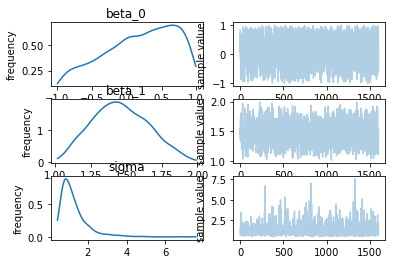

In [115]:
stan_regress.plot()

The posterior distributions in the left-hand plots above are summarized in the table below.  In our previous model where we allowed only discrete distributions for the parameters, we decided that $\beta_0 = 1$ and $\beta_1 = 1.25$ provided our single best regression line.  Switching to continuous distributions for our current model makes some difference compared to our previous model, but the results look roughly similar.  The posterior distribution for $\beta_0$ appears to peak around $0.7$ (a value that we didn't allow previously) rather than $1$, but those are fairly close.  The posterior distribution for $\beta_1$ appears to peak around $1.4$, which isn't that different from $1.25$.

In [51]:
stan_regress

Inference for Stan model: anon_model_765761058c29d104a20a7fb6cff8da77.
2 chains, each with iter=1000; warmup=200; thin=1; 
post-warmup draws per chain=800, total post-warmup draws=1600.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta_0   0.17    0.02   0.53  -0.89  -0.22   0.24   0.61   0.93    758    1.0
beta_1   1.46  7.2e-3    0.2   1.11   1.32   1.45    1.6   1.85    750    1.0
sigma    1.27    0.03   0.73   0.54    0.8   1.07   1.49    3.3    572   1.01
lp__    -5.36    0.07   1.47   -8.8  -6.17  -4.99  -4.22  -3.51    412   1.01

Samples were drawn using NUTS at Wed Apr 18 13:38:36 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

### III) C. Plot regression lines

Below is the plot of our data.  It now has three regression lines:

1. Red:  $\beta_0 = 0$, $\beta_1 = 1.5$, from our first model where we calculated a discrete distribution only for $\beta_1$
2. Blue:  $\beta_0 = 1$, $\beta_1 = 1.25$, from our second model where we calculated discrete distributions for $\beta_0$ and $\beta_1$
3. Green:  $\beta_0 = 0.17$, $\beta_1 = 1.46$, from our current Stan model where we calculated continuous distributions for $\beta_0$ and $\beta_1$

/home/zh/anaconda3/envs/jupyter_plot_stan/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


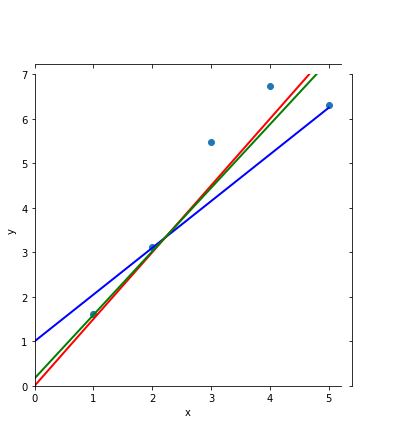

In [134]:
model_b0_1 = 0
model_b1_1 = 1.5

model_b0_2 = 1
model_b1_2 = 1.25

model_b0_3 = stan_regress.summary()['summary'][0, 0]
model_b1_3 = stan_regress.summary()['summary'][1, 0]

grid = sns.JointGrid(data_1['x'], data_1['y'])
grid.plot_joint(plt.scatter)
plt.xlim(xmin=0)
plt.ylim(ymin=0)
grid.ax_joint.plot([0, max(x)], [model_b0_2, max(x)*model_b1_2], 'b-', linewidth=2)
grid.ax_joint.plot([0, max(x)], [model_b0_1, max(x)*model_b1_1], 'r-', linewidth=2)
grid.ax_joint.plot([0, max(x)], [model_b0_3, max(x)*model_b1_3], 'g-', linewidth=2)
grid.fig

However, plotting only the single best regression line from our model leaves out a lot of information.  With full posterior distributions of our parameters -- not just point estimates of our parameters -- we can get a probabilistic idea of the full range of possible regression lines.  We can do that by sampling our parameters and plotting the resulting lines.

In [53]:
beta_0s = stan_regress.extract(permuted=True)['beta_0']
beta_1s = stan_regress.extract(permuted=True)['beta_1']

regress_lines_n = 500

beta_0s_sample = np.random.choice(beta_0s, regress_lines_n)
beta_1s_sample = np.random.choice(beta_1s, regress_lines_n)

/home/zh/anaconda3/envs/jupyter_plot_stan/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


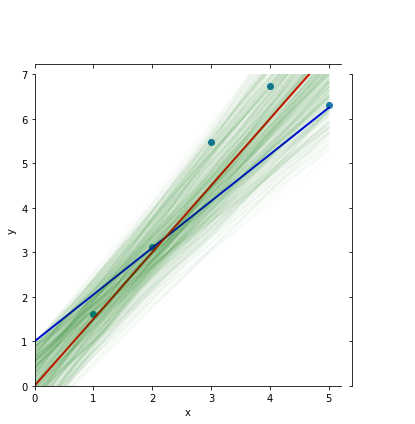

In [135]:
model_b0_1 = 0
model_b1_1 = 1.5

model_b0_2 = 1
model_b1_2 = 1.25

grid = sns.JointGrid(data_1['x'], data_1['y'])
grid.plot_joint(plt.scatter)
plt.xlim(xmin=0)
plt.ylim(ymin=0)
grid.ax_joint.plot([0, max(x)], [model_b0_2, max(x)*model_b1_2], 'b-', linewidth=2)
grid.ax_joint.plot([0, max(x)], [model_b0_1, max(x)*model_b1_1], 'r-', linewidth=2)
for i in range(regress_lines_n):
    model_b0_3 = beta_0s_sample[i]
    model_b1_3 = beta_1s_sample[i]
    grid.ax_joint.plot([0, max(x)], [model_b0_3, max(x)*model_b1_3], 'g-', linewidth=2, alpha=0.02)
#plt.show()
grid.fig

The cloud of green in the plot above represents a multitude of regression lines generated by our model.  Notice that the lines vary by both their $y$-intercepts ($\beta_0$) and their slopes ($\beta_1$).

## Part IV.  Conclusion

We have now seen how Bayes's rule is applied to linear regression.  The rule is applied to each parameter of a linear regression model.  We looked at no more than 2 parameters, but the process of setting the joint prior, calculating the joint likelihood, finding their product, and dividing by a scaling factor is basically the same when we add more parameters.  Looking at discrete, range-restricted distributions for each parameter made the calculations simple enough that we could easily follow them, but then we also saw how to implement our simple model in Stan.  That will hopefully prime you to look further at Stan or other probabilistic programming languages as you work towards more complex models.

### *Editorial comments / potential improvements*

- *the 3D plots for the likelihood and posterior are currently hard to see; a 3D contour or wire-frame plot will probably work better, but I haven't figured out how to implement these yet*
- *I wanted to show the prior, likelihood, and posterior plots from left-to-right to match their arrangement in the data frame, but couldn't figure out how to do it.  It probably wouldn't work for the 3D plots, but it might be helpful for the 2D plots*
- *I'm basically using a probability density function to calculate a probability mass function; I think the scaling means it doesn't matter, but maybe some rigorous statisticians would freak out and uncover some important assumption of why I can't do it; but it seems to get good results, and it makes sense, so I think it's fine*
- *the Stan plot is too small; I can't figure out how to enlarge it*
- *it would be nice to have another part between part 2 and part 3; it would involve coding up a simple sampling algorithm and using it to sample from the joint posterior distribution based on the linear regression model with 2 parameters; that would be something of a middle step of showing how to work with continuous distributions without jumping all the way to Stan*
- *I've ignored several issues in an effort to focus the presentation:*
    1) *how to select a flat (improper) prior for continuous distributions can be controversial; Stan's defaults are smartly chosen by those way smarter than I am, but I might currently be giving the impression that this choice is simple, easy, and no big deal*
    2) *I've left the regression likelihood calculation as an unexplained black box; I was afraid that explaining it would bog down the discussion and move it too far from the Bayesian aspects of the model*
    3) *likewise, I don't explain the closed-form calculation for linear regression (the 'predict_y' function; but again, I don't really want to do a tutorial on linear regression in general; I want to focus on the Bayesian aspect; one way to accommodate these issues without bogging it down too much would be to nod to them and provide links to discussions or tutorials/resources about them*